In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Printing/output settings

In [2]:
pd.set_option('display.max_colwidth', None)

# Explanatory Data Analysis

### Load data

We will load only positives reviews (rating > 3) from the database.

In [3]:
reviews = pd.read_sql(f"""
    SELECT podcast_id, author_id, rating, reviews.created_at , reviews.title, reviews.content 
    FROM reviews
    Where rating > 3
""", sqlite3.connect("initial_data/database.sqlite"))

podcast_w_category = pd.read_sql(f"""
    SELECT podcast_id, title as p_title, category
    FROM categories JOIN podcasts USING (podcast_id)
""", sqlite3.connect("initial_data/database.sqlite"))

Each podcast has multiple categories so we will concatenate them 
into a single string and will handle them as a single category for now.

In [ ]:
# for each podcast, concatenate all categories once you sort them
podcast_w_category = podcast_w_category.groupby("podcast_id").agg({"p_title": "first", "category": lambda x: "#".join(sorted(x))}).reset_index()

In [ ]:
# sort by aurhor_id, podcast_id and created_at
reviews = reviews.sort_values(by=['author_id', 'podcast_id', 'created_at'])

### Removing duplicates reviews
Users might review a podcast more than once. We keep only the latest review.

In [ ]:
# check if there are any duplicates
duplicates = reviews.duplicated(subset=['author_id','podcast_id'], keep='last')
total_duplicates = duplicates.shape[0] - (duplicates.shape[0] - duplicates.sum())

# remove based on boolean mask
reviews = reviews[~duplicates]
print(f'Removed {total_duplicates} duplicates ~ {round(duplicates.sum()/duplicates.shape[0],3)}% of total reviews')

Removed 59619 duplicates ~ 0.033% of total reviews


### Removing reviews with podcast_id not in podcasts table
There are reviews that their podcast id is not in the podcast table so we do not have any info about them.

In [ ]:
# get all podcast ids in podcast_w_category
pod_id_in_table = podcast_w_category['podcast_id'].unique()
# remove all author ids that are in reviews but not in podcast_w_category
before = reviews.shape[0]
reviews = reviews[reviews['podcast_id'].isin(pod_id_in_table)]
after = reviews.shape[0]
print(f'Removed {before - after} reviews ~ {round((before - after)/before,3)}% of total reviews')

Removed 21579 reviews ~ 0.012% of total reviews


### Keeping only authors with more than N reviews

In [ ]:
# # show number of unique authors per n, print diff percentage from initial and plot the results
# all_authors = reviews["author_id"].unique().shape[0]
# authors_n = {3:None, 4:None, 5:None, 6:None, 7:None, 8:None, 9:None, 10:None}
# for n in authors_n.keys():
#     authors_n[n] = reviews.groupby('author_id').filter(lambda x: len(x) >= n)['author_id'].unique().shape[0]
#     print(f'For n: {n} kept {authors_n[n]} authors ~ {round(authors_n[n]/all_authors,3)}% of total authors')

# plt.bar(authors_n.keys(), authors_n.values())
# plt.xlabel('n')
# plt.ylabel('number of authors')
# plt.title('Number of authors kept for different n')
# plt.show()

In [ ]:
# Keep only authors with at least K reviews
K = 4
reviews = reviews.groupby('author_id').filter(lambda x: len(x) >= K)

In [ ]:
# print unique authors and reviews
print(f'Unique authors: {reviews["author_id"].unique().shape[0]}')
print(f'Unique reviews: {reviews.shape[0]}')

Unique authors: 33047
Unique reviews: 214630


### Creating the final dataset

In [ ]:
# merge reviews with podcast_w_category
reviews_w_podcast_w_category = reviews.merge(podcast_w_category, on='podcast_id', how='inner')
# keep only the columns we need
reviews_w_podcast_w_category = reviews_w_podcast_w_category[['author_id', 'podcast_id', 'p_title', 'category', 'rating', 'created_at']]
reviews_w_podcast_w_category = reviews_w_podcast_w_category.sort_values(by=['author_id', 'created_at'], ascending=False)

In [ ]:
print(reviews_w_podcast_w_category.columns)
print(reviews_w_podcast_w_category.head(10))
# clean memory
del  reviews
del podcast_w_category


Index(['author_id', 'podcast_id', 'p_title', 'category', 'rating',
       'created_at'],
      dtype='object')
              author_id                        podcast_id  \
64324   FFFA87613ADA48A  dfe8c6d0dfe36f106f3df419e4abdebf   
127239  FFFA87613ADA48A  b299f17e7c8ce4eea5312f9a6e2e1efc   
104160  FFFA87613ADA48A  e402101e20153b710fea9f707c462204   
63284   FFFA87613ADA48A  b5cf7d57fdf09b9e4177a0afb8cd467f   
27157   FFF559CD2875885  f5f405721f37e3311a58f07da974c756   
108410  FFF559CD2875885  d90bfe6641533109ad8becc21057319e   
200357  FFF559CD2875885  accd597caede356b5b920ed044847925   
23164   FFF559CD2875885  bf5bf76d5b6ffbf9a31bba4480383b7f   
739     FFF559CD2875885  b1a3eb2aa8e82ecbe9c91ed9a963c362   
120187  FFF171657D896FA  d8d94c2dd8822e1f541909b6161a84c9   

                              p_title  \
64324                        Ruthless   
127239                     Cwic Media   
104160             The American Story   
63284          The Glenn Beck Program   
27157       

In [ ]:
### We have 3 ideas for the clustering:
#  1. Cluster based on the average rating of the categories
#       We will represent each author as a vector of size 108 (at the total number of most frequent categories)
#       Each element of the vector will be the average rating of the author for the category
#       We will use KMeans to cluster the authors

#  2. Cluster based on the K most recent reviews
#       We will represent each author as a vector of size K, where each element is a podcast title
#       We will use KModes to cluster the authors
#  3. Cluster based on the K most recent reviews

#       We will represent each author as a vector of size K, where each element is a podcast category
#       We will use KModes to cluster the authors


### Idea 1

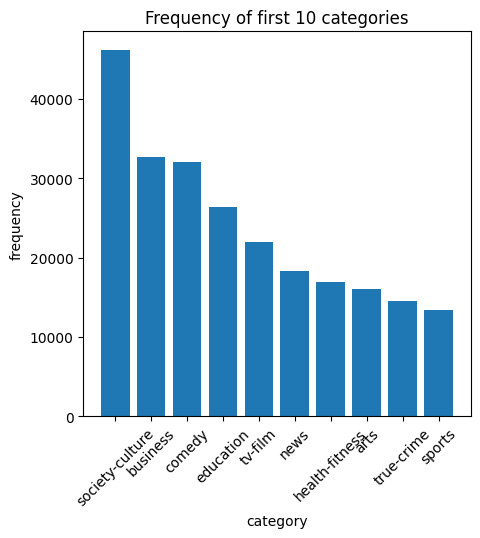

In [ ]:
# Compute frequency of each category
category_freq = reviews_w_podcast_w_category['category'].str.split('#').explode().value_counts().to_dict()
# plot first 10 categories
plt.figure(figsize=(5,5))
plt.bar(list(category_freq.keys())[:10], list(category_freq.values())[:10])
plt.xticks(rotation=45)
plt.xlabel('category')
plt.ylabel('frequency')
plt.title('Frequency of first 10 categories')
plt.show()

In [ ]:
# Idea 1 
# Each author is a datapoint with 109 features (categories) 0-1

# Create datapoint for each author with index as author_id
datapoints = reviews_w_podcast_w_category[['author_id', 'category','created_at','rating']].copy()
datapoints = datapoints.sort_values(by=['author_id', 'created_at'], ascending=False)
# Replace category with most frequent category of the combined categories which podcast has
datapoints['category'] = datapoints['category'].str.split('#').apply(lambda x: max(x, key=lambda y: category_freq[y]))
authors = datapoints['author_id'].unique()
print(datapoints['category'].unique().shape[0])



import time
start_time = time.time()

matrix_all_categories = pd.DataFrame(index=authors, columns=datapoints['category'].unique())
matrix_all_categories = matrix_all_categories.fillna(0)
matrix_all_categories_freq = pd.DataFrame(index=authors, columns=datapoints['category'].unique())
matrix_all_categories_freq = matrix_all_categories_freq.fillna(0)


for i, row in enumerate(datapoints.itertuples()):
    i = i + 1
    matrix_all_categories.loc[row.author_id, row.category] = row.rating
    matrix_all_categories_freq.loc[row.author_id, row.category] += 1

    if i % 100 == 0:
        print(f'{i} reviews processed ~ {round(i/datapoints.shape[0],3)}% of total reviews ~ {round((time.time() - start_time)/60,3)} minutes elapsed ~ {round((time.time() - start_time)/60/(i/datapoints.shape[0]),3)} minutes remaining')

# normalize the matrix
matrix_all_categories = matrix_all_categories.div(matrix_all_categories_freq, axis=0)




109
100 reviews processed ~ 0.0% of total reviews ~ 0.093 minutes elapsed ~ 199.63 minutes remaining
200 reviews processed ~ 0.001% of total reviews ~ 0.094 minutes elapsed ~ 100.655 minutes remaining
300 reviews processed ~ 0.001% of total reviews ~ 0.095 minutes elapsed ~ 67.632 minutes remaining
400 reviews processed ~ 0.002% of total reviews ~ 0.095 minutes elapsed ~ 51.098 minutes remaining
500 reviews processed ~ 0.002% of total reviews ~ 0.096 minutes elapsed ~ 41.159 minutes remaining
600 reviews processed ~ 0.003% of total reviews ~ 0.097 minutes elapsed ~ 34.556 minutes remaining
700 reviews processed ~ 0.003% of total reviews ~ 0.097 minutes elapsed ~ 29.836 minutes remaining
800 reviews processed ~ 0.004% of total reviews ~ 0.098 minutes elapsed ~ 26.28 minutes remaining
900 reviews processed ~ 0.004% of total reviews ~ 0.099 minutes elapsed ~ 23.516 minutes remaining
1000 reviews processed ~ 0.005% of total reviews ~ 0.099 minutes elapsed ~ 21.307 minutes remaining
1100 re

In [ ]:
matrix_all_categories = matrix_all_categories.fillna(0)

k: 2, iterations: 15
k: 3, iterations: 15
k: 4, iterations: 14
k: 5, iterations: 23
k: 6, iterations: 28
k: 7, iterations: 26
k: 8, iterations: 16
k: 9, iterations: 28
k: 10, iterations: 27
k: 11, iterations: 39
k: 12, iterations: 30
k: 13, iterations: 30
k: 14, iterations: 34
k: 15, iterations: 26
k: 16, iterations: 28
k: 17, iterations: 30
k: 18, iterations: 27
k: 19, iterations: 49
k: 20, iterations: 33
k: 21, iterations: 37
k: 22, iterations: 37
k: 23, iterations: 29
k: 24, iterations: 22
k: 30, iterations: 25
k: 35, iterations: 29
k: 40, iterations: 28
k: 50, iterations: 33
k: 60, iterations: 38


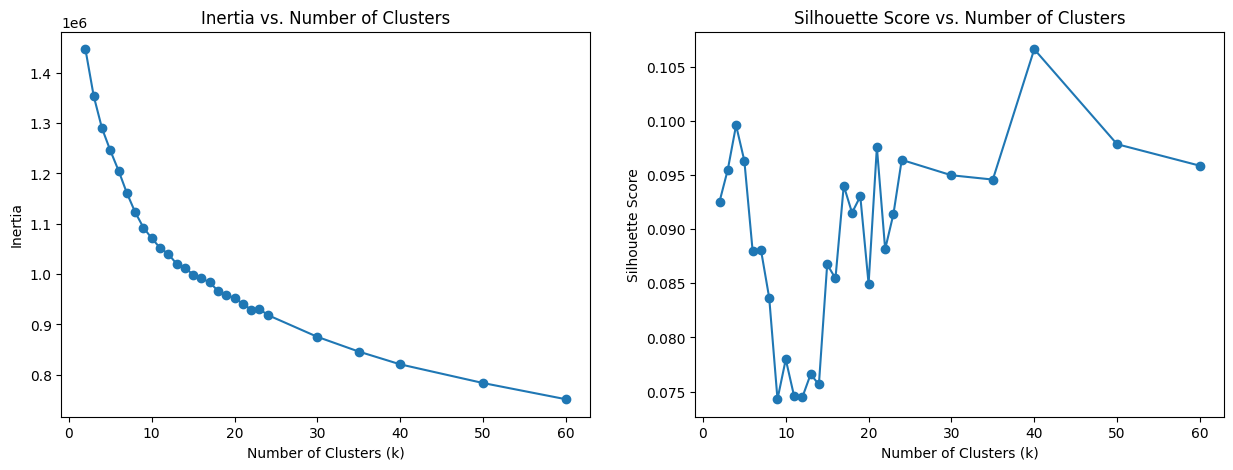

In [ ]:
# Clustering of matrix_all_categories

# import the necessary packages
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np

# create a list of K values
K_clusters = list(range(2, 25))
K_clusters.extend([30,35,40,50,60])
inertias = []
silhouette_scores = []
# loop over K values
for k in K_clusters:
    # create a KMeans instance with k clusters
    kmeans = KMeans(n_clusters=k, max_iter=100, random_state=42)
    # fit the model to the matrix
    kmeans.fit(matrix_all_categories)
    # siluette score
    silhouette_avg = metrics.silhouette_score(matrix_all_categories, kmeans.labels_)
    silhouette_scores.append(silhouette_avg)
    # get the inertia
    inertias.append(kmeans.inertia_)
    # print the number of iterations required to converge
    print(f'k: {k}, iterations: {kmeans.n_iter_}')

# plot the inertias and silhouette scores for each K value in two separate plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(K_clusters, inertias, '-o')
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Inertia vs. Number of Clusters')

ax2.plot(K_clusters, silhouette_scores, '-o')
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score vs. Number of Clusters')
plt.show()


In [ ]:
# Assign the cluster labels to the matrix
matrix_all_categories['cluster'] = kmeans.labels_

### Idea 2

In [ ]:
# Keep the K most recent reviews for each author
reviews_w_podcast_w_category_k = reviews_w_podcast_w_category.groupby('author_id').head(K)
authors = reviews_w_podcast_w_category_k['author_id'].unique()
total_authors = authors.shape[0]
print(f'Unique authors: {total_authors}')

Unique authors: 33047


In [ ]:
# Idea 2
# Each author is a datapoint with K features (podcast titles)
datapoints = reviews_w_podcast_w_category_k[['author_id', 'p_title', 'created_at', 'rating']]
# populate the matrix
matrix_K_titles = pd.DataFrame(index=authors, columns=['title_' + str(i) for i in range(K)])
matrix_K_titles = matrix_K_titles.fillna("empty")
# fill the matrix with the average rating of the author for the podcast title in order
print(matrix_K_titles.shape)
print(authors.shape)
print(K)
for index, author in enumerate (authors):
    index = index + 1
    titles = datapoints[datapoints['author_id'] == author]['p_title'].values
    for i in range(K):
        matrix_K_titles.loc[author, 'title_' + str(i)] = titles[i]
    # keep track of progress
    if index % 3000 == 0:
        print(f'{index} authors processed')

(33047, 4)
(33047,)
4
3000 authors processed
6000 authors processed
9000 authors processed
12000 authors processed
15000 authors processed
18000 authors processed
21000 authors processed
24000 authors processed
27000 authors processed
30000 authors processed
33000 authors processed


(33047, 4)
For K: 2 -> Max iterations: 1  Cost: 131271.0 Time: 0.063 minutes
For K: 3 -> Max iterations: 1  Cost: 131010.0 Time: 0.1 minutes
For K: 4 -> Max iterations: 1  Cost: 130733.0 Time: 0.119 minutes
For K: 5 -> Max iterations: 1  Cost: 130538.0 Time: 0.083 minutes
For K: 6 -> Max iterations: 1  Cost: 130271.0 Time: 0.096 minutes
For K: 7 -> Max iterations: 1  Cost: 130112.0 Time: 0.088 minutes
For K: 8 -> Max iterations: 1  Cost: 129883.0 Time: 0.142 minutes
For K: 9 -> Max iterations: 1  Cost: 129815.0 Time: 0.086 minutes
For K: 10 -> Max iterations: 2  Cost: 129652.0 Time: 0.168 minutes
For K: 11 -> Max iterations: 2  Cost: 129502.0 Time: 0.129 minutes
For K: 12 -> Max iterations: 2  Cost: 129415.0 Time: 0.127 minutes
For K: 13 -> Max iterations: 2  Cost: 129378.0 Time: 0.13 minutes
For K: 14 -> Max iterations: 2  Cost: 129150.0 Time: 0.185 minutes
For K: 15 -> Max iterations: 2  Cost: 129028.0 Time: 0.143 minutes
For K: 16 -> Max iterations: 2  Cost: 128990.0 Time: 0.143 min

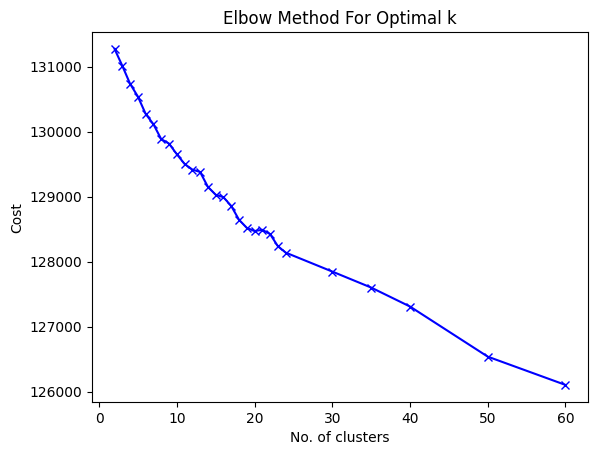

In [ ]:
# Categorical data clustering
# Import the necessary packages

# Check source: https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/
# Check source: https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7
matrix_K_titles = matrix_K_titles.astype('str')
print(matrix_K_titles.shape)
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
import numpy as np

# create a list of K values
K_clusters = list(range(2, 25))
K_clusters.extend([30,35,40,50,60])

# create a list of silhouette scores
cost = []

# loop over K values
import time

for k in K_clusters:
    start_time = time.time()
    # create a KMeans instance with k clusters
    kmodes = KModes(n_clusters=k, init = "Cao", verbose=0 , max_iter=100, n_jobs=1, random_state=42)
    # fit the model to the matrix
    kmodes.fit(matrix_K_titles)
    # get the cost
    cost.append(kmodes.cost_)
    # print max iterations of the algorithm
    end_time = time.time()
    print(f"For K: {k} -> Max iterations: {kmodes.n_iter_}  Cost: {kmodes.cost_} Time: {round((end_time - start_time)/60,3)} minutes")
    # get centroids
    #print(f"Centroids: {kmodes.cluster_centroids_}")
# plot the results
plt.plot(K_clusters, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# Assign the cluster labels to the matrix
matrix_K_titles['cluster'] = kmodes.labels_

### Idea 3

In [ ]:
# Idea 3
# Each author is a datapoint with K features (podcast categories)
datapoints = reviews_w_podcast_w_category_k[['author_id', 'category', 'created_at', 'rating']]
# populate the matrix
matrix_K_categories = pd.DataFrame(index=authors, columns=['category_' + str(i) for i in range(K)])
matrix_K_categories = matrix_K_categories.fillna("empty")
# fill the matrix with the average rating of the author for the podcast title in order
for index, author in enumerate (authors):
    index = index + 1
    categories = datapoints[datapoints['author_id'] == author]['category'].values
    for i in range(K):
        matrix_K_categories.loc[author, 'category_' + str(i)] = categories[i]
    if index % 3000 == 0:
        print(f'{index} authors processed')

3000 authors processed
6000 authors processed
9000 authors processed
12000 authors processed
15000 authors processed
18000 authors processed
21000 authors processed
24000 authors processed
27000 authors processed
30000 authors processed
33000 authors processed


(33047, 4)
For K: 2 -> Max iterations: 1  Cost: 122762.0 Time: 0.059 minutes
For K: 3 -> Max iterations: 1  Cost: 119624.0 Time: 0.123 minutes
For K: 4 -> Max iterations: 1  Cost: 117101.0 Time: 0.081 minutes
For K: 5 -> Max iterations: 1  Cost: 116845.0 Time: 0.092 minutes
For K: 6 -> Max iterations: 1  Cost: 116619.0 Time: 0.093 minutes
For K: 7 -> Max iterations: 1  Cost: 116226.0 Time: 0.06 minutes
For K: 8 -> Max iterations: 2  Cost: 114317.0 Time: 0.129 minutes
For K: 9 -> Max iterations: 2  Cost: 113978.0 Time: 0.107 minutes
For K: 10 -> Max iterations: 2  Cost: 113712.0 Time: 0.132 minutes
For K: 11 -> Max iterations: 2  Cost: 113415.0 Time: 0.117 minutes
For K: 12 -> Max iterations: 2  Cost: 113102.0 Time: 0.129 minutes
For K: 13 -> Max iterations: 2  Cost: 112792.0 Time: 0.121 minutes
For K: 14 -> Max iterations: 2  Cost: 112533.0 Time: 0.134 minutes
For K: 15 -> Max iterations: 2  Cost: 112373.0 Time: 0.16 minutes
For K: 16 -> Max iterations: 4  Cost: 111791.0 Time: 0.22 min

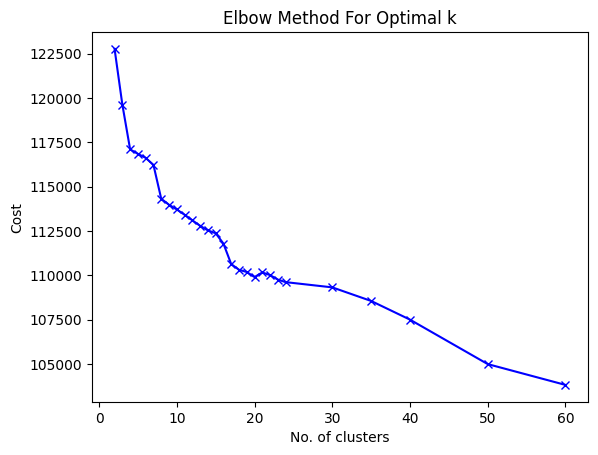

In [ ]:
# Categorical data clustering
# Import the necessary packages

# Check source: https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/
# Check source: https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7
matrix_K_categories = matrix_K_categories.astype('str')
print(matrix_K_categories.shape)
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt
import numpy as np

# create a list of K values
K_clusters = list(range(2, 25))
K_clusters.extend([30,35,40,50,60])

# create a list of silhouette scores
cost = []

# loop over K values
import time

for k in K_clusters:
    start_time = time.time()
    # create a KMeans instance with k clusters
    kmodes = KModes(n_clusters=k, init = "Cao", verbose=0 , max_iter=100, n_jobs=1, random_state=42)
    # fit the model to the matrix
    kmodes.fit(matrix_K_categories)
    # get the cost
    cost.append(kmodes.cost_)
    # print max iterations of the algorithm
    end_time = time.time()
    print(f"For K: {k} -> Max iterations: {kmodes.n_iter_}  Cost: {kmodes.cost_} Time: {round((end_time - start_time)/60,3)} minutes")
    # get centroids
    #print(f"Centroids: {kmodes.cluster_centroids_}")
# plot the results
plt.plot(K_clusters, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# Assign the cluster labels to the matrix
matrix_K_categories['cluster'] = kmodes.labels_

In [ ]:
# Idea 1 results
# get unique authors and their cluster labels
authors_clusters_1 = matrix_all_categories[['cluster']].reset_index().drop_duplicates()
# make author_id a column
authors_clusters_1 = authors_clusters_1.rename(columns={'index': 'author_id'})
print(authors_clusters_1.shape)
print(authors_clusters_1.columns)

# get the number of authors in each cluster as percentage
authors_clusters_1['count'] = 1
authors_clusters_1_count = authors_clusters_1.groupby('cluster').count().reset_index()
authors_clusters_1['percentage'] = authors_clusters_1.groupby('cluster')['author_id'].transform('count')/authors_clusters_1.shape[0]
authors_clusters_1 = authors_clusters_1.sort_values(by='count', ascending=False)
print(authors_clusters_1['cluster'].value_counts())
print(authors_clusters_1)
authors_clusters_1_result = authors_clusters_1[['author_id', 'cluster']]

# Idea 2 results
authors_clusters_2 = matrix_K_titles[['cluster']].reset_index().drop_duplicates()
# make author_id a column
authors_clusters_2 = authors_clusters_2.rename(columns={'index': 'author_id'})
# get the number of authors in each cluster
authors_clusters_2['count'] = 1
authors_clusters_2 = authors_clusters_2.groupby('cluster').count().reset_index()
authors_clusters_2['percentage'] = authors_clusters_2.groupby('cluster')['author_id'].transform('count')/authors_clusters_2.shape[0]
authors_clusters_2 = authors_clusters_2.sort_values(by='count', ascending=False)
print(authors_clusters_2)
authors_clusters_2_result = authors_clusters_2[['author_id', 'cluster']]

# Idea 3 results
authors_clusters_3 = matrix_K_categories[['cluster']].reset_index().drop_duplicates()
# make author_id a column
authors_clusters_3 = authors_clusters_3.rename(columns={'index': 'author_id'})
# get the number of authors in each cluster
authors_clusters_3['count'] = 1
authors_clusters_3 = authors_clusters_3.groupby('cluster').count().reset_index()
authors_clusters_3['percentage'] = authors_clusters_3.groupby('cluster')['author_id'].transform('count')/authors_clusters_3.shape[0]
authors_clusters_3 = authors_clusters_3.sort_values(by='count', ascending=False)
print(authors_clusters_3)
# get only author_id and cluster
authors_clusters_3_result = authors_clusters_3[['author_id', 'cluster']]

# store the results
authors_clusters_1_result.to_csv('authors_clusters_1_6rev_result.csv', index=False)
authors_clusters_2_result.to_csv('authors_clusters_2_6rev_result.csv', index=False)
authors_clusters_3_result.to_csv('authors_clusters_3_6rev_result.csv', index=False)

(33047, 2)
Index(['author_id', 'cluster'], dtype='object')
29    2084
3     1477
30    1198
6     1197
1     1053
14     939
15     903
46     883
53     868
45     817
2      760
17     723
37     670
43     670
24     650
31     598
18     595
51     584
16     583
23     562
12     545
28     534
20     525
38     520
21     513
7      498
56     491
48     484
10     481
49     458
8      446
34     436
11     422
26     421
19     413
55     402
0      395
41     389
22     381
42     379
57     365
35     361
52     357
9      357
36     356
27     352
13     351
59     351
33     349
39     339
5      321
32     319
54     307
47     304
44     290
58     270
25     206
50     192
4      181
40     172
Name: cluster, dtype: int64
             author_id  cluster  count  percentage
0      FFFA87613ADA48A       31      1    0.018095
22011  5500E857E8C95F8       51      1    0.017672
22041  54C6EBDED081E84       43      1    0.020274
22040  54CB8C6E3EE75D6        0      1    0.01195